In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from scipy.stats import shapiro 
import scipy.stats as stats
import random
from random import choice
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pycaret.classification import *

In [2]:
df = pd.read_csv('/Users/darigazaikenova/PycharmProjects/TEST_Trader_Quant_dataset.csv')

In [3]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
0,74.23525,124.000,23.000,149.187,7.459,7.872,257.347,77.510,86.753,0,...,15582,6.8649,44,533,201481,85873,42474,237989,69445,33461
1,74.17525,33.105,280.280,133.749,0.709,31.305,87.454,51.044,130.774,2,...,13398,6.8589,45012,63355,230732,84898,45959,155027,45111,44533
2,74.18325,375.086,323.644,170.037,3.999,25.476,168.794,72.876,270.396,2,...,12777,6.8595,27710,55091,247450,98765,43705,206995,74398,42840
3,74.17625,48.775,25.853,93.927,39.872,14.148,72.699,65.654,352.091,0,...,14498,6.8595,32364,39759,237211,95343,35553,217658,75365,53509
4,74.17125,48.774,301.886,90.637,30.003,20.829,201.224,24.241,96.640,0,...,14704,6.8583,17667,52192,236698,102647,44195,196868,74185,19152


## Identifying outliers and reducing the dimensionality of the data

In [4]:
df.dropna(inplace=True)

##### Isolation Forest and Principal Component Analysis (PCA)

Isolation Forest is used to identify the anomalies/outliers of the data. And the PCA is used to visualise the anomalies and the normal data in 2D

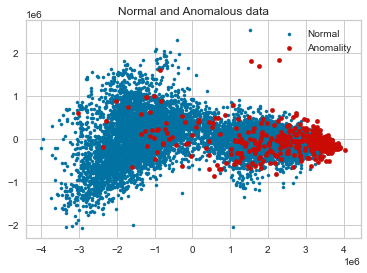

In [5]:
# Isolation Forest model to identify outliers
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(df.values)
outliers = df[model.predict(df.values) == -1]

# PCA - transforming df and outliers into 2D
pca = PCA(n_components=2)
pca_df = pca.fit_transform(df)
pca_outliers = pca.transform(outliers)

# Scatter Plot
plt.scatter(pca_df[:,0], pca_df[:,1], s=10, label = 'Normal')
plt.scatter(pca_outliers[:,0], pca_outliers[:,1], s=20, c='r', label='Anomality')
plt.title('Normal and Anomalous data')
plt.legend()
plt.show()


Most of the abnormal data is coming from the left side of the plot which means that there is some underlying pattern or structure in the high-dimensional time series data that separates the abnormal data from the normal data. This could be due to differences in the values or patterns in specific columns or groups of columns.

##### Identifying the columns responsible for abnormalities

In [6]:
loadings = pca.components_[0]

# sorting the loadings in descending order of absolute values
sorted_indices = loadings.argsort()[::-1]
sorted_loadings = loadings[sorted_indices]

col_names = list(df.columns)
anomaly = [{'Feature Name': col_names[i], 'Importance': loading} for i, loading in zip(sorted_indices, sorted_loadings)]
df_anomaly = pd.DataFrame(anomaly)
df_anomaly.head()

,Feature Name,Importance
0,32,0.060903
1,31,0.053078
2,50,0.022604
3,49,0.020767
4,41,0.003171


To conclude, the feature that is the most responsible for abnormalities in the dataset is column '32'

## Regression Analysis

##### 1. Check if the data is normally ditributed

In [7]:
# normality using Shapiro test

normality = {}
list1=[]
for i in df.columns:
    stat, p  = shapiro(df[i])
    normality[i] = p

key=list(normality.keys())
val=list(normality.values())

#if p > 0.05, the data in column is normal
indices = [i for i, x in enumerate(val) if x > 0.05] 
norm_col = [key[i] for i in indices]
norm_col

['20', '29']

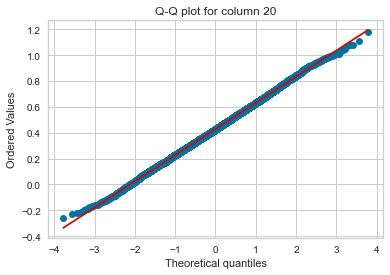

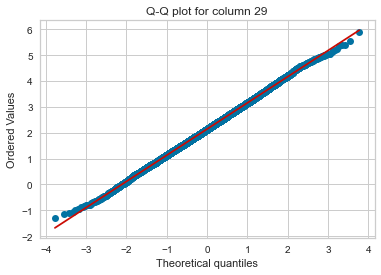

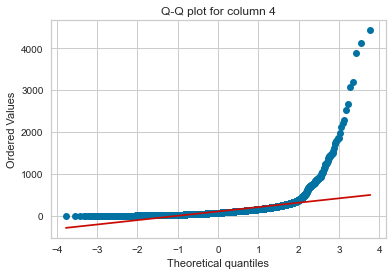

In [8]:
# normality using Q-Q Plot

random.seed(123)
random_column = str(choice([i for i in range(1,56) if i not in [20,29]]))
for i in ['20', '29',random_column]:
    stats.probplot(df[i], dist="norm", plot=plt)
    plt.title(f"Q-Q plot for column {i}")
    plt.show()


According to Shapiro Test and Q-Q Plot, only columns '20' and '29' are normally distributed. Others, are not. For instance, randomly chosen column "4" is positively skewed as seen in Q-Q Plot.

##### Since most of the data is not normal, I will use the random forest regression analysis. Compared to linear regression, it doesn't require the data to be normal and it can handle the outliers.

#### 2. Correlation and Heatmap
Identifying columns with the highest correlation

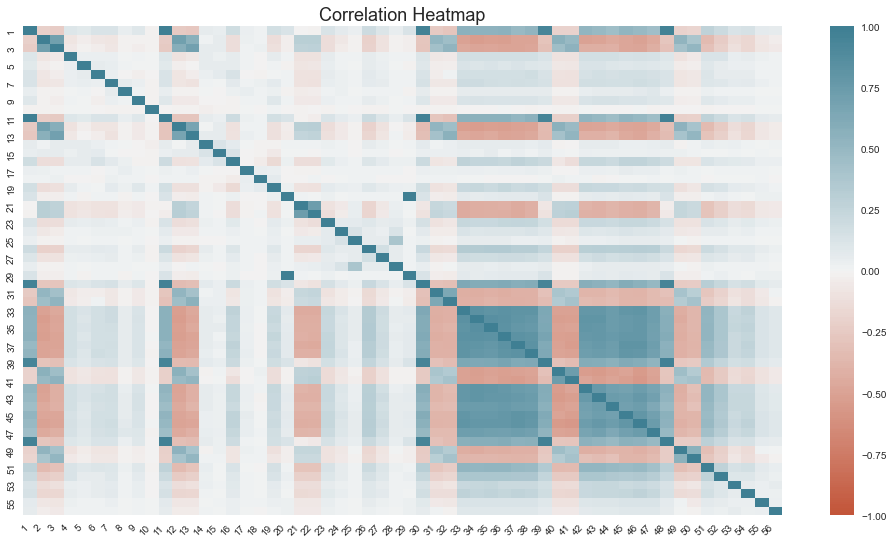

In [9]:
corr = df.corr()

#fig, ax = plt.subplots(figsize=(17,9)) 
fig = plt.figure(figsize=(17, 9))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
ax.set_title('Correlation Heatmap', size=18)
plt.show()

Pair with the Highest Correlation (0.99 and more)

In [10]:
corr_matrix = df.corr()#.abs()
high_corr_var = np.where(corr_matrix>0.99)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

# corr 0.99 and higher is between ('1', '11') and ('20', '29') columns/features

[('1', '11'), ('20', '29')]

Paiir with the Lowest Correlation 

In [11]:
# identifying the minimum correlation in the matrix
corr_matrix = df.corr()
corr_matrix.describe().loc['min'].min() 

-0.5635393037201831

In [12]:
corr_matrix = df.corr()
low_corr_var = np.where(corr_matrix< -0.55)
low_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*low_corr_var) if x!=y and x<y]
low_corr_var

# pair ('41', '46') has the lowest correlation of -0.56

[('41', '46')]

#### 3. Illustration using Linear Regression
Since both columns in the pair ('20', '29') are normally distributed accroding to Shapiro test and Q-Q Plot, for this pair we can plot the linear regression

Linear Regression for pair ('20', '29')

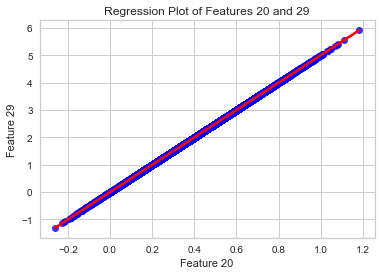

In [13]:
sns.regplot(x="20", y="29", data=df, line_kws={"color":"red"}, scatter_kws={"color":"blue"})
plt.title('Regression Plot of Features 20 and 29')
plt.xlabel('Feature 20')
plt.ylabel('Feature 29')
plt.show()

#### 4. Illustration using the Random Forest Regression

Here, I predict the values of the column '11' using the Random Forest Regression.
Column '11' is randomly chosen

In [14]:
X = df.drop(df.columns[10], axis=1).copy().values #column 11 has index 10
y = df.iloc[:, 10].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

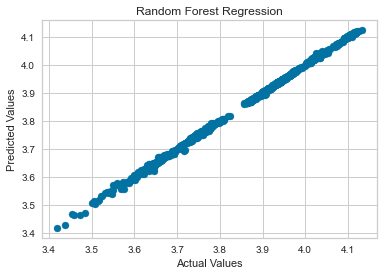

In [15]:
y_pred = rf.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression')
plt.show()

In [16]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE is', rmse)

RMSE is 0.0031044350894129623


In [17]:
errors = abs(y_pred - y_test)

print('Mean Absolute Error is', round(np.mean(errors), 2), 'degrees')

Mean Absolute Error is 0.0 degrees


In [18]:
mape = np.zeros_like(errors)
mask = y_test != 0
mape[mask] = 100 * (errors[mask] / y_test[mask])
mape[~mask] = np.nan
mape = np.abs(mape)
mape = np.nan_to_num(mape, nan=0.0, posinf=0.0, neginf=0.0)
accuracy = 100 - np.mean(mape)
print('Accuracy is', round(accuracy, 2), '%')

Accuracy is 99.95 %


In [19]:
importances = list(rf.feature_importances_)
features_names = list(df.drop(df.columns[10], axis=1).columns)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

pycaret = [{'Variable': pair[0], 'Importance': pair[1]} for pair in feature_importances]
df_pycaret = pd.DataFrame(pycaret)
df_pycaret.head()

,Variable,Importance
0,30,0.90
1,1,0.08
2,48,0.02
3,2,0.00
4,3,0.00


Visualizing the importance of different columns/features on prediction

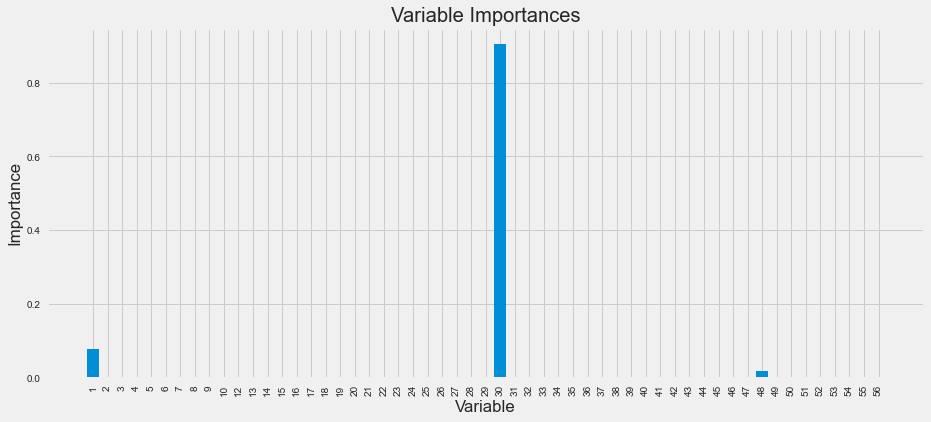

In [20]:
%matplotlib inline

plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))

fig = plt.figure(figsize=(14, 6))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features_names, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

To conclude, the scatter plot of predicted vs actual values form a diagonal line. This mean that the model is almost perfectly predict the target column '11'. From further analysis we derive that accuracy of the model is 99.95% and the column that is most important in predicting column '11' is column '30'

#### 4. Categorizing the new data using Pycaret

In [21]:
# Analyzing if there is any categorical values

col_name = list(df.columns)

unique_dict={}
for i in col_name:
    v = df[i].unique()
    unique_dict[i] = v
    
length_dict = {key: len(value) for key, value in unique_dict.items()}
categorical_col=[]
for i in col_name:
    if length_dict[i] < 100:
        categorical_col.append(i)
        
categorical_dict={}        
for i in categorical_col:
    categorical_dict[i] = unique_dict[i]
    
categorical_dict 

#the only categorical column in df is col '10' and it has 3 values: 0,1,2

{'10': array([0, 2, 1])}

In the df the column '10' is categorical. Thus, in the later part let's predict if the new data belongs to the category 0,1,or 2 in the column '10'

In [22]:
train_size = 0.05
train_end = int(len(df)*0.5)

df_train = df[:train_end]
df_test = df[train_end:]

In [23]:
setup(df_train, target='10')

,Description,Value
0,Session id,4535
1,Target,10
2,Target type,Multiclass
3,Original data shape,"(4344, 56)"
4,Transformed data shape,"(4344, 56)"
5,Transformed train set shape,"(3040, 56)"
6,Transformed test set shape,"(1304, 56)"
7,Numeric features,55
8,Preprocess,1
9,Imputation type,simple


In [24]:
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.3378,0.5115,0.3378,0.3335,0.3280,0.0050,0.0052,0.0530
dummy,Dummy Classifier,0.3378,0.5000,0.3378,0.1141,0.1706,0.0000,0.0000,0.0290
nb,Naive Bayes,0.3382,0.4985,0.3382,0.3334,0.2369,0.0070,0.0114,0.0320
qda,Quadratic Discriminant Analysis,0.3342,0.4967,0.3342,0.3210,0.2529,0.0011,0.0016,0.0350
dt,Decision Tree Classifier,0.3286,0.4965,0.3286,0.3290,0.3281,-0.0070,-0.0070,0.0310
lda,Linear Discriminant Analysis,0.3276,0.4925,0.3276,0.3276,0.3269,-0.0088,-0.0089,0.0430
lr,Logistic Regression,0.3326,0.4901,0.3326,0.3327,0.3315,-0.0014,-0.0014,0.8660
ada,Ada Boost Classifier,0.3145,0.4832,0.3145,0.3139,0.3131,-0.0287,-0.0288,0.0660
et,Extra Trees Classifier,0.3122,0.4823,0.3122,0.3111,0.3107,-0.0322,-0.0323,0.1630
rf,Random Forest Classifier,0.3207,0.4809,0.3207,0.3209,0.3193,-0.0196,-0.0196,0.1370


In [25]:
predict_model(best_model) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.3290,0.4812,0.3290,0.3262,0.3199,-0.0084,-0.0086


,1,2,3,4,5,6,7,8,9,11,...,50,51,52,53,54,55,56,10,prediction_label,prediction_score
3040,73.733749,390.665985,30.945000,71.028999,96.111000,36.808998,84.004997,29.913000,48.928001,3.92931,...,2615,201435,62964,81856,270474,145293,44332,2,2,0.6
3041,74.453751,143.839996,175.229004,122.475998,2.058000,22.903999,279.687012,27.752001,82.122002,3.95081,...,717,182681,73786,43376,182431,70784,24862,1,2,0.6
3042,74.270248,13.119000,55.518002,649.466980,28.340000,8.239000,82.639000,39.648998,374.799011,3.95159,...,11563,261575,159934,46996,251585,66086,24388,1,1,0.4
3043,74.080750,162.042999,54.918999,118.927002,65.236000,2.030000,123.248001,60.918999,189.567001,3.94043,...,18854,253593,88171,37067,251200,61019,44259,0,0,0.6
3044,74.025253,31.649000,50.007999,58.807999,12.690000,44.328999,288.152008,50.014999,105.252998,3.93733,...,5228,261319,103193,42040,185459,78004,40929,2,1,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,74.273750,18.764999,33.639000,117.452003,39.597000,50.498001,74.149002,20.868000,18.261999,3.94685,...,40554,159986,48966,48442,283146,142509,57726,0,0,0.8
4340,72.463753,251.203003,219.384995,55.514000,94.742996,10.883000,178.255997,41.347000,76.217003,3.88999,...,85677,175987,72651,21368,171343,91163,21857,2,0,0.4
4341,74.275749,185.253006,240.988998,14.487000,8.824000,6.730000,298.583008,22.106001,240.589996,3.94569,...,43735,171440,47766,31880,199783,67387,32849,2,1,0.6
4342,74.070251,31.472000,31.497999,181.110992,24.521999,37.318001,178.746994,63.103001,93.757004,3.94233,...,75388,153544,50833,40085,158070,69460,34341,0,1,0.6


To conclude, we can use the Quadratic Discriminant Analysis to predict what will be the value of column '10' in the new data. However, it is important to note that although the model has the highest AUC, still it's accurate only to 34.10% and AUC is 0.4999